c:\Users\Muhamad\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Missing values in dataset:
 MedInc        0
HouseAge      0
AveRooms      0
AveBedrms     0
Population    0
AveOccup      0
Latitude      0
Longitude     0
dtype: int64


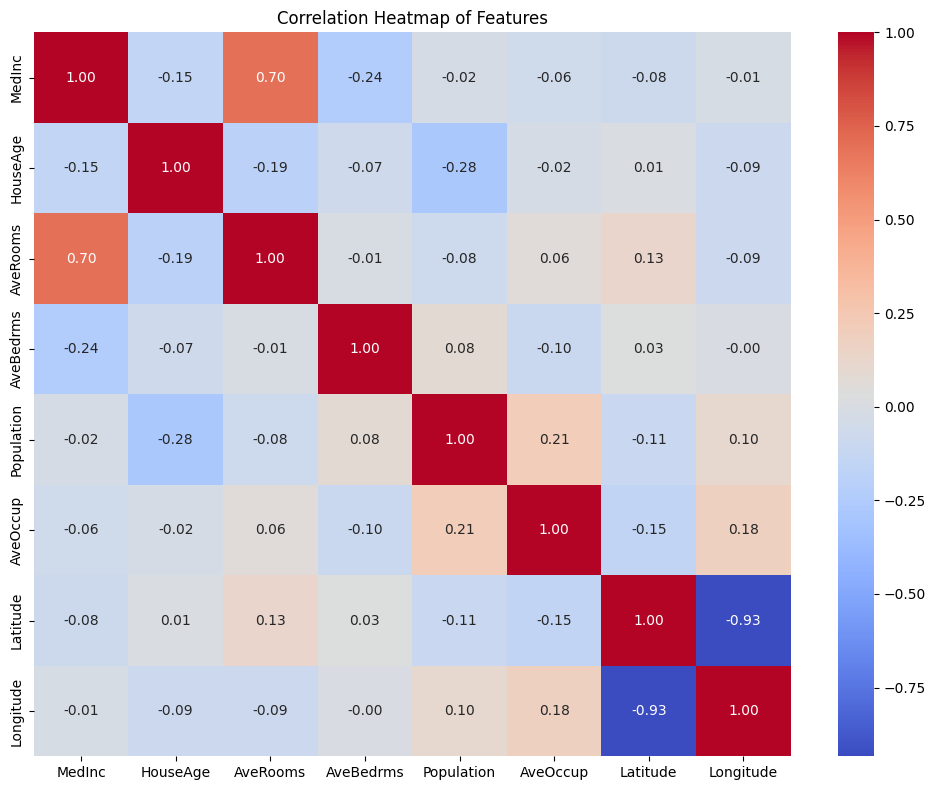

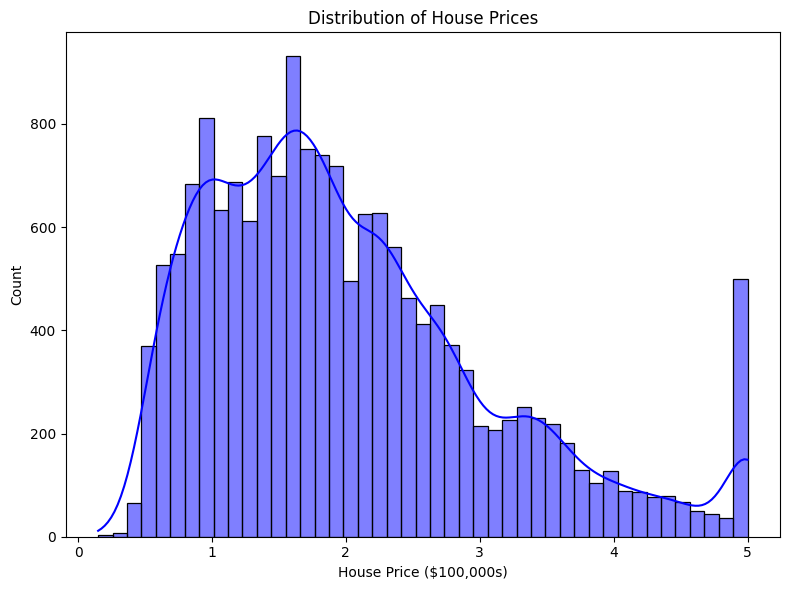

Mean Squared Error: 0.23
R^2 Score: 0.80


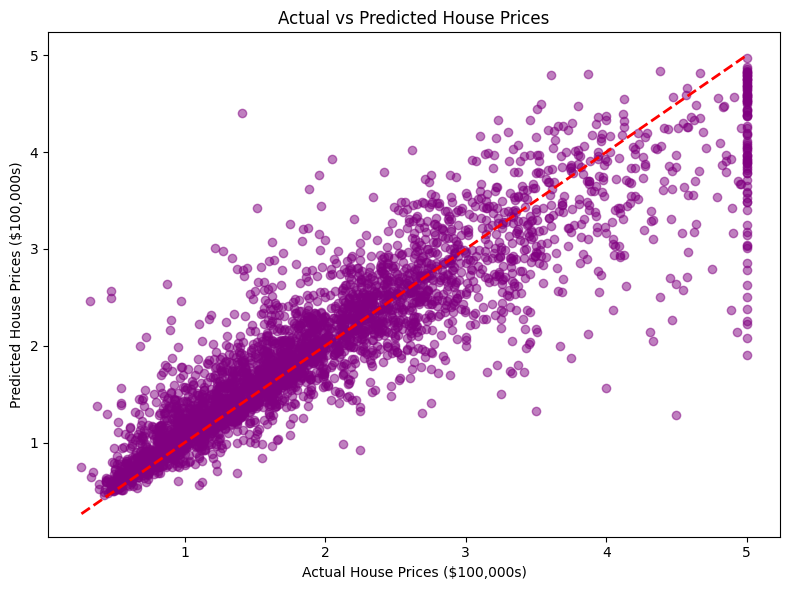

In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import shap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

# Set random seed for reproducibility
np.random.seed(42)

# Step 1: Load and clean the data
data = fetch_california_housing()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = data.target

# Check for missing values
print("Missing values in dataset:\n", X.isnull().sum())

# Check for outliers using IQR
def remove_outliers(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df

# Apply outlier removal to relevant columns (e.g., 'MedInc', 'AveRooms', 'AveBedrms')
numeric_cols = ['MedInc', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup']
X_clean = remove_outliers(X.copy(), numeric_cols)
y_clean = y[X_clean.index]

# Scale features
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_clean), columns=X_clean.columns, index=X_clean.index)

# Step 2: Data exploration visualizations
# Correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(X_clean.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of Features')
plt.tight_layout()
plt.show()

# Distribution of target variable
plt.figure(figsize=(8, 6))
sns.histplot(y_clean, kde=True, color='blue')
plt.title('Distribution of House Prices')
plt.xlabel('House Price ($100,000s)')
plt.tight_layout()
plt.show()

# Step 3: Split data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_clean, test_size=0.2, random_state=42)

# Step 4: Train Random Forest model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Step 5: Evaluate model
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse:.2f}")
print(f"R^2 Score: {r2:.2f}")

# Visualization: Actual vs Predicted
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5, color='purple')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual House Prices ($100,000s)')
plt.ylabel('Predicted House Prices ($100,000s)')
plt.title('Actual vs Predicted House Prices')
plt.tight_layout()
plt.show()

# Step 6: SHAP analysis
# Initialize SHAP explainer
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

# SHAP Visualization 1: Feature importance (bar plot)
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_test, plot_type="bar")
plt.title("SHAP Feature Importance")
plt.tight_layout()
plt.show()

# SHAP Visualization 2: Summary plot (feature impact)
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_test)
plt.title("SHAP Summary Plot")
plt.tight_layout()
plt.show()

# SHAP Visualization 3: Dependence plot for 'MedInc'
plt.figure(figsize=(8, 6))
shap.dependence_plot("MedInc", shap_values, X_test, interaction_index=None)
plt.title("SHAP Dependence Plot for Median Income")
plt.tight_layout()
plt.show()

# SHAP Visualization 4: Force plot for a single prediction
sample_idx = 0
print(f"\nExplaining prediction for sample {sample_idx}:")
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[sample_idx], X_test.iloc[sample_idx], matplotlib=True)
plt.title(f"SHAP Force Plot for Sample {sample_idx}")
plt.tight_layout()
plt.show()

# Print SHAP values for the sample
sample_shap_values = pd.Series(shap_values[sample_idx], index=X_test.columns)
print(f"SHAP values for sample {sample_idx}:\n{sample_shap_values.sort_values(ascending=False)}")